In [2]:
# from IPython.core.display import display HTML
# display(HTML(""))
import pandas as pd
import numpy as np
import pickle
import re
import datetime as dt
import scipy.stats as stats

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from operator import itemgetter, attrgetter, methodcaller

In [3]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.cross_validation import train_test_split 
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LinearRegression

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [73]:
def diagnostic_plot(y, pred):
    plt.figure(figsize=(20,8))
    res = y - pred
    
    plt.subplot(1, 3, 1)
    plt.scatter(y, pred)
    plt.plot(np.linspace(y.min()-0.01*np.mean(y), y.max()+0.01*np.mean(y), 1000),
         np.linspace(y.min()-0.01*np.mean(y), y.max()+0.01*np.mean(y), 1000),
        color='m', linestyle='--')
    plt.title("Actual vs. Predicted", size=15)
    plt.xlabel("Actual", size=15)
    plt.ylabel("Predicted", size=15)

    plt.subplot(1, 3, 2)
    plt.scatter(pred, res)
    plt.plot(np.linspace(pred.min()-0.01*np.mean(pred), pred.max()+0.01*np.mean(pred), 1000), 
             np.linspace(0, 0, 1000), 
             color='m', linestyle='--')
    plt.title("Residual plot of Y-Predict", size=15)
    plt.xlabel("Prediction", size=15)
    plt.ylabel("Residuals", size=15)

    plt.subplot(1, 3, 3)
    stats.probplot(res, dist="norm", plot=plt)
    plt.xlabel("Theoretical Quantiles", size=15)
    plt.ylabel("Ordered Values", size=15)
    plt.title("Normal Q-Q plot", size=15)

In [9]:
# compute with R^2 formulas from the theory
def calc_Rsq(y, pred):
    SS_Residual = sum((y-pred)**2)
    SS_Total = sum((y-np.mean(y))**2)
    r_squared = 1 - (float(SS_Residual))/SS_Total
    adjusted_r_squared = 1 - (1-r_squared)*(len(y)-1)/(len(y)-X.shape[1]-1)
    mean_root_error = np.sqrt(np.mean((y - pred)**2))
    return ({'r_squared: ': r_squared, 
             'adjusted_r_squared: ': adjusted_r_squared, 
             'mean_root_error: ': mean_root_error})

In [10]:
with open("coffee_master_cleaned2.pkl", 'rb') as picklefile: 
    df = pickle.load(picklefile)

In [11]:
df.columns
df.columns=[x.replace('-', '_').replace('/ ', '').replace(' ', '_').replace('(', '').replace(')', '') for x in df.columns]
df.columns

Index(['Total_Score', 'Altitude', 'Harvest_year', 'Acidity', 'Sweetness',
       'Moisture', 'Defects_cat1', 'Quakers', 'Defects_cat2', 'Grading_year',
       'total_weight', 'Quakers_gr', 'Country_Brazil', 'Country_Burundi',
       'Country_China', 'Country_Colombia', 'Country_Costa_Rica',
       'Country_Cote_d?Ivoire', 'Country_Ecuador', 'Country_El_Salvador',
       'Country_Ethiopia', 'Country_Guatemala', 'Country_Haiti',
       'Country_Honduras', 'Country_India', 'Country_Indonesia',
       'Country_Japan', 'Country_Kenya', 'Country_Laos', 'Country_Malawi',
       'Country_Mauritius', 'Country_Mexico', 'Country_Myanmar',
       'Country_Nicaragua', 'Country_Panama', 'Country_Papua_New_Guinea',
       'Country_Peru', 'Country_Philippines', 'Country_Rwanda',
       'Country_Taiwan', 'Country_Tanzania,_United_Republic_Of',
       'Country_Thailand', 'Country_Uganda', 'Country_United_States',
       'Country_United_States_Hawaii', 'Country_United_States_Puerto_Rico',
       'Country

In [12]:
# Dummies removed: Total_Score, 'Harvest_year', Color_None, Variety_gr_nan,'Country_United_States', 'Processing_meth_Other'
features=['Altitude',  'Acidity', 'Sweetness',
       'Moisture', 'Defects_cat1', 'Quakers', 'Defects_cat2', 'Grading_year',
       'total_weight', 'Quakers_gr', 'Country_Brazil', 'Country_Burundi',
       'Country_China', 'Country_Colombia', 'Country_Costa_Rica',
       'Country_Cote_d?Ivoire', 'Country_Ecuador', 'Country_El_Salvador',
       'Country_Ethiopia', 'Country_Guatemala', 'Country_Haiti',
       'Country_Honduras', 'Country_India', 'Country_Indonesia',
       'Country_Japan', 'Country_Kenya', 'Country_Laos', 'Country_Malawi',
       'Country_Mauritius', 'Country_Mexico', 'Country_Myanmar',
       'Country_Nicaragua', 'Country_Panama', 'Country_Papua_New_Guinea',
       'Country_Peru', 'Country_Philippines', 'Country_Rwanda',
       'Country_Taiwan', 'Country_Tanzania,_United_Republic_Of',
       'Country_Thailand', 'Country_Uganda',
       'Country_United_States_Hawaii', 'Country_United_States_Puerto_Rico',
       'Country_Vietnam', 'Country_Zambia', 'Variety_gr_Bourbon',
       'Variety_gr_Catimor', 'Variety_gr_Catuai', 'Variety_gr_Caturra',
       'Variety_gr_Gesha', 'Variety_gr_Hawaiian_Kona', 'Variety_gr_Mundo_Novo',
       'Variety_gr_Other', 'Variety_gr_Pacas', 'Variety_gr_SL14',
       'Variety_gr_SL28', 'Variety_gr_Typica', 'Variety_gr_Yellow_Bourbon',
       'Processing_meth_Natural_Dry',
       'Processing_meth_Pulped_natural_honey',
       'Processing_meth_Semi_washed_Semi_pulped', 'Processing_meth_Washed_Wet',
       'Color_Blue_Green', 'Color_Bluish_Green', 'Color_Green']

df[['Total_Score']+features].head()

,Total_Score,Altitude,Acidity,Sweetness,Moisture,Defects_cat1,Quakers,Defects_cat2,Grading_year,total_weight,...,Variety_gr_SL28,Variety_gr_Typica,Variety_gr_Yellow_Bourbon,Processing_meth_Natural_Dry,Processing_meth_Pulped_natural_honey,Processing_meth_Semi_washed_Semi_pulped,Processing_meth_Washed_Wet,Color_Blue_Green,Color_Bluish_Green,Color_Green
0,79.67,1264.0,7.17,10.0,0.00,0,0,9,2012,253.0,...,0,0,0,0,0,0,1,0,0,0
1,80.17,1100.0,7.33,10.0,0.11,0,0,2,2015,550.0,...,0,0,0,0,0,0,1,0,0,0
2,81.67,1200.0,7.42,10.0,0.12,0,0,0,2015,1200.0,...,0,0,0,0,0,0,1,0,0,1
3,81.67,1200.0,7.42,10.0,0.11,0,0,2,2012,275.0,...,0,0,0,0,0,0,1,0,0,1
4,80.42,600.0,7.25,10.0,0.11,0,0,0,2013,300.0,...,0,1,0,0,0,0,1,0,0,1


(array([  11.,    7.,   10.,   30.,   40.,   61.,   92.,  138.,  195.,
         246.,  210.,  143.,   78.,   39.,   20.,   13.,    8.,    6.,
           1.,    2.]),
 array([ 75.58,  76.33,  77.08,  77.83,  78.58,  79.33,  80.08,  80.83,
         81.58,  82.33,  83.08,  83.83,  84.58,  85.33,  86.08,  86.83,
         87.58,  88.33,  89.08,  89.83,  90.58]),
 <a list of 20 Patch objects>)

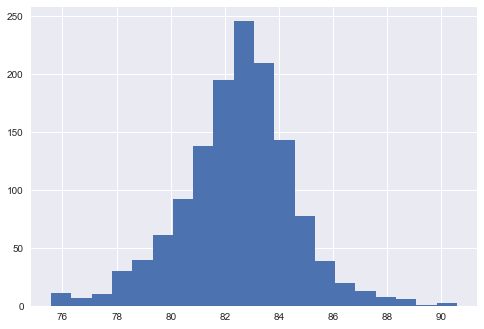

In [180]:
plt.hist(df['Total_Score'], bins=20)

In [181]:
corr=df[['Total_Score']+features].corr()
corr
# Total score is highly correlated to Acidity, sweetness, defect 2 (-), altitude
# Defect 1 and 2 are correlated, altitude & Acidity, acidity and defect 2, moisture and defect 2, grading year and quakers 
# Brazil, Colombia, Ethiopia, Variety_gr_Other, Variety_gr_Typica, Processing_meth_Washed / Wet

,Total_Score,Altitude,Acidity,Sweetness,Moisture,Defects_cat1,Quakers,Defects_cat2,Grading_year,total_weight,...,Variety_gr_SL28,Variety_gr_Typica,Variety_gr_Yellow_Bourbon,Processing_meth_Natural_Dry,Processing_meth_Pulped_natural_honey,Processing_meth_Semi_washed_Semi_pulped,Processing_meth_Washed_Wet,Color_Blue_Green,Color_Bluish_Green,Color_Green
Total_Score,1.000000,0.166101,0.751048,0.217662,-0.160747,-0.090999,-0.043967,-0.217251,0.008197,0.039445,...,0.079730,-0.204460,-0.000808,0.046914,0.025809,0.019264,-0.115210,0.076146,0.052184,-0.126776
Altitude,0.166101,1.000000,0.163946,0.025046,-0.023386,-0.084050,0.007864,-0.004331,0.032562,-0.029194,...,0.041525,-0.194056,-0.107831,-0.113967,-0.011483,-0.056661,0.128188,0.029630,0.012280,-0.016201
Acidity,0.751048,0.163946,1.000000,-0.025020,-0.119456,-0.047241,-0.043232,-0.131112,-0.020283,0.023243,...,0.091050,-0.173196,-0.043633,0.020277,0.002417,-0.006709,-0.052934,0.069837,0.041495,-0.092504
Sweetness,0.217662,0.025046,-0.025020,1.000000,0.058178,-0.054152,-0.068749,-0.104374,0.020986,0.018550,...,0.005895,0.029627,0.022561,-0.109646,0.021936,0.009420,0.079851,0.010192,-0.019938,0.051047
Moisture,-0.160747,-0.023386,-0.119456,0.058178,1.000000,0.038014,-0.005242,0.135503,0.015054,0.017485,...,-0.011024,0.147107,-0.110463,-0.060445,0.021271,0.065112,0.176615,-0.010076,0.044573,0.196781
Defects_cat1,-0.090999,-0.084050,-0.047241,-0.054152,0.038014,1.000000,0.012805,0.325769,-0.060920,-0.020341,...,-0.019579,0.028200,-0.025315,0.099897,-0.020512,-0.030898,-0.060359,-0.006810,-0.037258,0.008458
Quakers,-0.043967,0.007864,-0.043232,-0.068749,-0.005242,0.012805,1.000000,0.124977,0.308246,0.047713,...,-0.024208,-0.066512,-0.000172,0.036533,0.145178,-0.047510,-0.033188,-0.051495,-0.005770,0.092059
Defects_cat2,-0.217251,-0.004331,-0.131112,-0.104374,0.135503,0.325769,0.124977,1.000000,-0.055732,-0.016662,...,-0.041298,0.086314,-0.035212,0.063181,-0.027012,0.002842,0.026143,-0.056244,-0.088313,0.100459
Grading_year,0.008197,0.032562,-0.020283,0.020986,0.015054,-0.060920,0.308246,-0.055732,1.000000,0.072874,...,0.037163,-0.164249,0.022806,0.111521,0.142409,-0.105630,0.139358,0.045390,0.058047,0.262982
total_weight,0.039445,-0.029194,0.023243,0.018550,0.017485,-0.020341,0.047713,-0.016662,0.072874,1.000000,...,0.104930,-0.044002,-0.013462,0.036657,-0.009089,-0.020154,-0.006742,-0.021865,0.047874,-0.010998


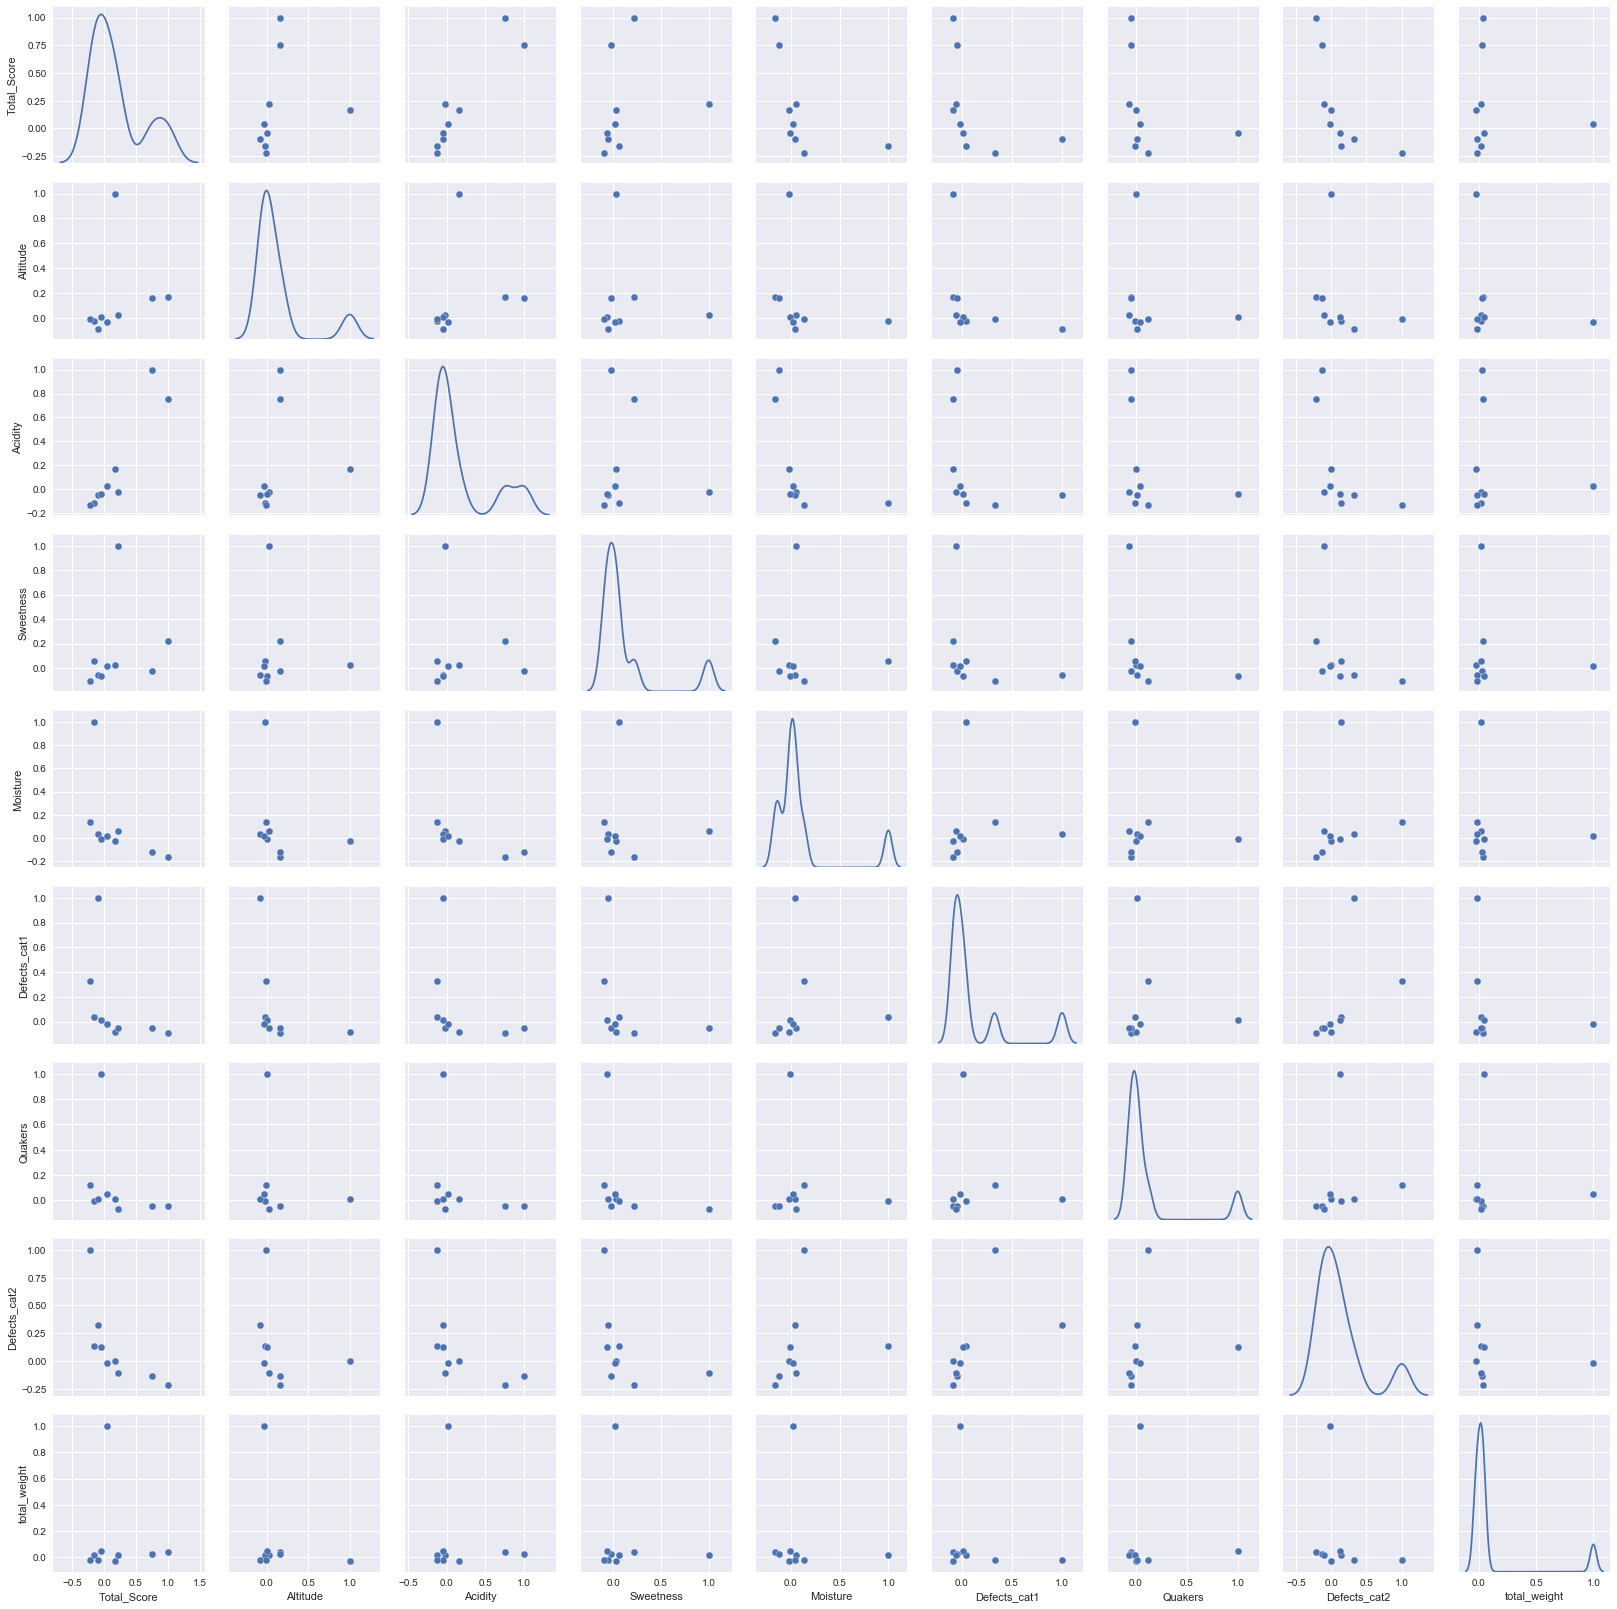

In [183]:
# feat_quant=['Total_Score', 'Altitude', 'Harvest_year', 'Acidity', 'Sweetness',
#        'Moisture', 'Defects_cat1', 'Quakers', 'Defects_cat2', 'Grading_year',
#        'total_weight']
# corr2=df[feat_quant].corr()
# sns.pairplot(corr2, size = 1.2, aspect=1.5);
feat_quant=['Total_Score', 'Altitude', 'Acidity', 'Sweetness',
       'Moisture', 'Defects_cat1', 'Quakers', 'Defects_cat2', 'total_weight']
corr2=df[feat_quant].corr()
sns.pairplot(corr2, diag_kind="kde");

In [ ]:
sns.heatmap(df[feat_quant].corr())

**Take care of the missings**  
Impute the Altitude with the Median


In [14]:
df[features].isnull().sum()[df[features].isnull().sum()>0]

Altitude    217
dtype: int64

In [15]:
df['Altitude'][df['Altitude'].isnull()]=df['Altitude'].median()
df['Altitude'].isnull().sum()

0

In [16]:
df[features].isnull().sum()[df[features].isnull().sum()>0]

Series([], dtype: int64)

**Train-Test Split**

In [17]:
X = df[features]
y = df['Total_Score']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

### Model 1 - Baseline using all columns untransformed to predict y_train
{'r_squared: ': 0.69106522817190585,   
'adjusted_r_squared: ': 0.67126171715728444,   
'mean_root_error: ': 1.1529903158215458}  
Model 1 CV Mean Squared Error:  1.52492964308

In [19]:
model1 = sm.OLS(y_train, sm.add_constant(X_train))
fit1 = model1.fit()
fit1.summary()
# Adj. R-squared on train: 0.671. 
# Sig: Acidity, Sweetness, Defect 2, Variety_gr_Typica, Country_United_States_Puerto_Rico, Country_India, constant, altitude

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Total_Score   R-squared:                       0.690
Model:                            OLS   Adj. R-squared:                  0.671
Method:                 Least Squares   F-statistic:                     35.94
Date:                Thu, 19 Jul 2018   Prob (F-statistic):          1.96e-214
Time:                        10:54:11   Log-Likelihood:                -1687.6
No. Observations:                1080   AIC:                             3503.
Df Residuals:                    1016   BIC:                             3822.
Df Model:                          63                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
const                                      86.1385     48.407      1.779      0.075      -8.851     181.128
Altitude                                 7.879e-05      0.000      0.657      0.512      -0.000       0.000
Acidity                                     4.6930      0.137     34.187      0.000       4.424       4.962
Sweetness                                   1.6813      0.120     14.045      0.000       1.446       1.916
Moisture                                   -0.6995      0.921     -0.759      0.448      -2.507       1.108
Defects_cat1                               -0.0406      0.031     -1.323      0.186      -0.101       0.020
Quakers                                    -0.1133      0.091     -1.247      0.213      -0.292       0.065
Defects_cat2                               -0.0261      0.009     -3.035      0.002      -0.043      -0.009
Grading_year                               -0.0274      0.024     -1.141      0.254      -0.075       0.020
total_weight                            -4.945e-08   8.85e-08     -0.559      0.576   -2.23e-07    1.24e-07
Quakers_gr                                  0.2085      0.133      1.570      0.117      -0.052       0.469
Country_Brazil                             -0.2395      0.554     -0.432      0.666      -1.326       0.847
Country_Burundi                            -1.6902      1.318     -1.283      0.200      -4.276       0.895
Country_China                              -0.4378      0.688     -0.636      0.525      -1.788       0.913
Country_Colombia                           -0.0599      0.535     -0.112      0.911      -1.110       0.990
Country_Costa_Rica                         -0.0600      0.558     -0.107      0.914      -1.156       1.036
Country_Cote_d?Ivoire                      -1.0783      1.325     -0.814      0.416      -3.679       1.522
Country_Ecuador                            -0.5941      1.323     -0.449      0.653      -3.189       2.001
Country_El_Salvador                         0.2925      0.588      0.497      0.619      -0.862       1.447
Country_Ethiopia                            0.2981      0.549      0.543      0.587      -0.779       1.375
Country_Guatemala                          -0.8814      0.538     -1.638      0.102      -1.937       0.174
Country_Haiti                              -0.5476      0.806     -0.680      0.497      -2.129       1.033
Country_Honduras                           -0.5106      0.562     -0.909      0.364      -1.613       0.592
Country_India                               3.2033      1.411      2.271      0.023       0.435       5.971
Country_Indonesia                          -0.5200      0.614     -0.847      0.397      -1.725       0.685
Country_Japan                           -1.749e-15   1.09e-

{'r_squared: ': 0.69025984837560361, 'adjusted_r_squared: ': 0.67040471045096284, 'mean_root_error: ': 1.154492235928843}
Model 1 CV Mean Squared Error:  1.53329417254


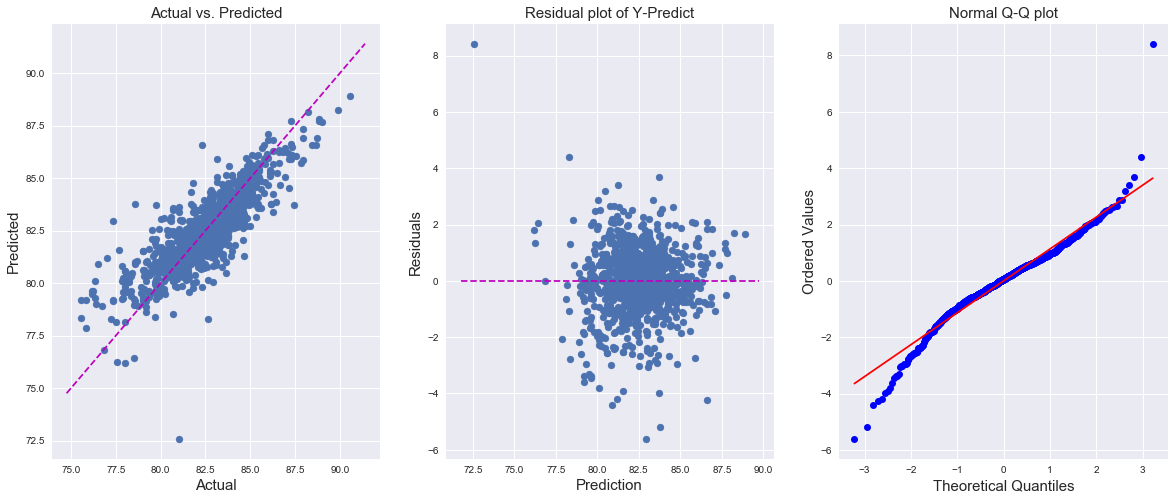

In [74]:
pred1 = fit1.predict(sm.add_constant(X_train))
print(calc_Rsq(y_train, pred1))

reg = LinearRegression()
scores = cross_val_score(reg, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
print("Model 1 CV Mean Squared Error: ", np.mean(-scores))

diagnostic_plot(y_train, pred1)

### Model 2
Transform some variables to logs because of skewedness, CV, no feature selection.   
{'r_squared: ': 0.68724963728712418,   
'adjusted_r_squared: ': 0.66720153711322183,   
'mean_root_error: ': 1.1600886406869575}  
Model 2 CV Mean Squared Error:  1.53306952377

(array([  1.02100000e+03,   3.30000000e+01,   8.00000000e+00,
          7.00000000e+00,   7.00000000e+00,   2.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00]),
 array([  0. ,   1.5,   3. ,   4.5,   6. ,   7.5,   9. ,  10.5,  12. ,
         13.5,  15. ]),
 <a list of 10 Patch objects>)

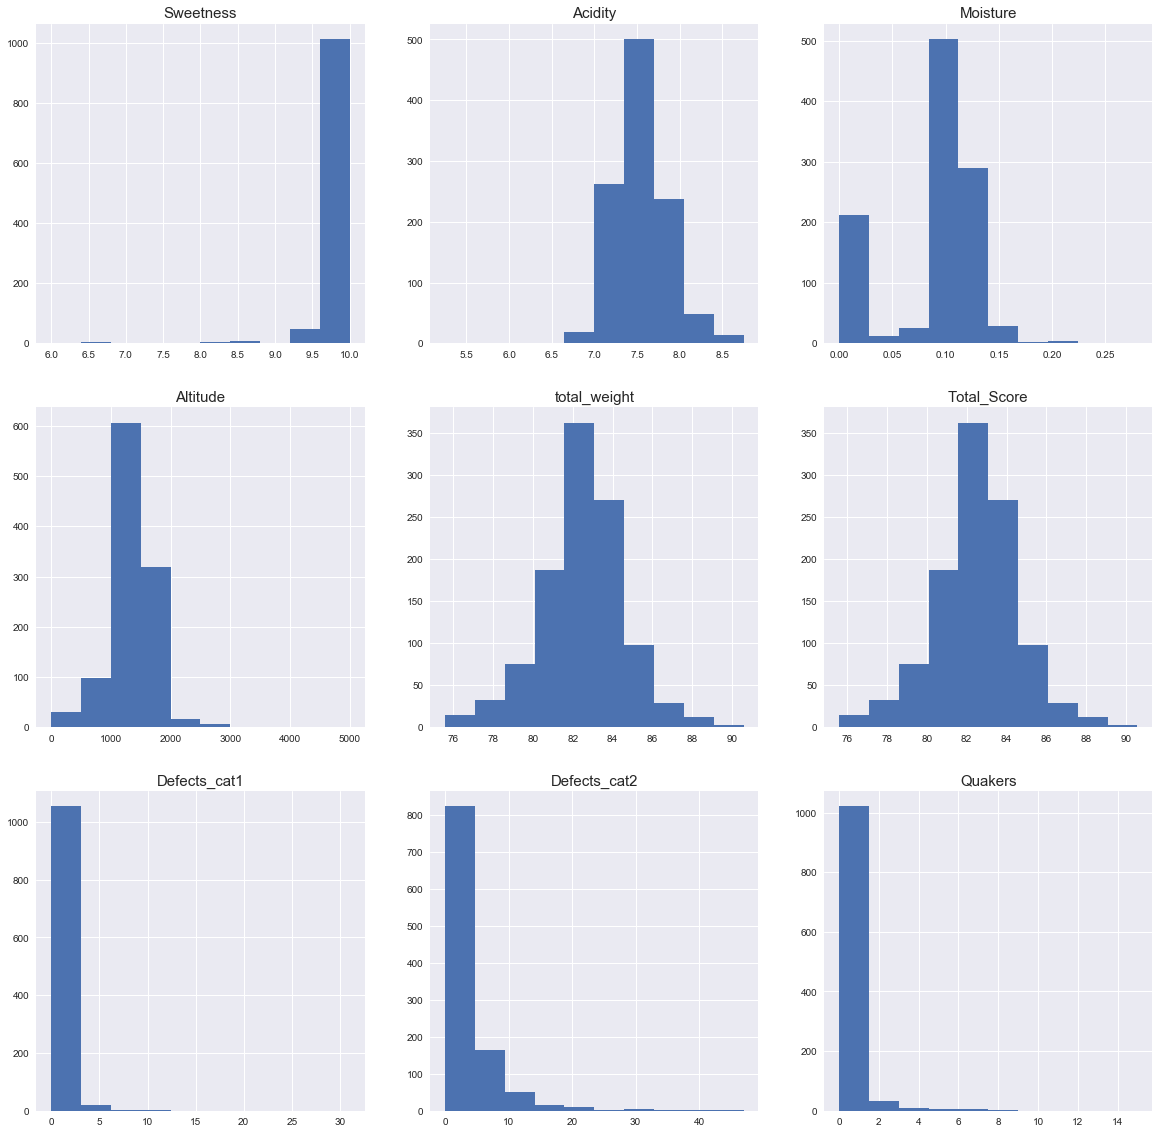

In [75]:
f, ax = plt.subplots(nrows=3, ncols=3, sharex=False, sharey=False, figsize=(20,20))

ax[0,0].set_title('Sweetness', size=15)
ax[0,0].hist(X_train['Sweetness'])
ax[0,1].set_title('Acidity', size=15)
ax[0,1].hist(X_train['Acidity'])
ax[0,2].set_title('Moisture', size=15)
ax[0,2].hist(X_train['Moisture'])

ax[1,0].set_title('Altitude', size=15)
ax[1,0].hist(X_train['Altitude'])
ax[1,1].set_title('total_weight', size=15)
ax[1,1].hist(y_train)
ax[1,2].set_title('Total_Score', size=15)
ax[1,2].hist(y_train)

ax[2,0].set_title('Defects_cat1', size=15)
ax[2,0].hist(X_train['Defects_cat1'])
ax[2,1].set_title('Defects_cat2', size=15)
ax[2,1].hist(X_train['Defects_cat2'])
ax[2,2].set_title('Quakers', size=15)
ax[2,2].hist(X_train['Quakers'])

Based on results above, I'm going to log the Sweetness, Altitude, Defects_cat1, Defects_cat2, Quakers.

In [76]:
def log_var(x):
    if x==0 or x=="nan": return 0
    else: return np.log(x)

In [77]:
X_train['Altitude_log'] = [log_var(x) for x in X_train['Altitude']]
X_train['Sweetness_log'] = [log_var(x) for x in X_train['Sweetness']]
X_train['Defects_cat1_log'] = [log_var(x) for x in X_train['Defects_cat1']]
X_train['Defects_cat2_log'] = [log_var(x) for x in X_train['Defects_cat2']]
X_train['Quakers_log'] = [log_var(x) for x in X_train['Quakers']]

In [ ]:
f, ax = plt.subplots(nrows=2, ncols=3, sharex=False, sharey=False, figsize=(20,20))

ax[0,0].set_title('Altitude_log', size=15)
ax[0,0].hist(X_train['Altitude_log'])
ax[0,1].set_title('Sweetness_log', size=15)
ax[0,1].hist(X_train['Sweetness_log'])
ax[0,2].set_title('Quakers_log', size=15)
ax[0,2].hist(X_train['Quakers_log'])

ax[1,0].set_title('Defects_cat1_log', size=15)
ax[1,0].hist(X_train['Defects_cat1_log'])
ax[1,1].set_title('Defects_cat2_log', size=15)
ax[1,1].hist(X_train['Defects_cat2_log'])


In [78]:
# Remove 'Altitude',  'Sweetness', 'Sweetness', 'Defects_cat1', 'Defects_cat2'
features2=[ 'Altitude_log', 'Sweetness_log', 'Quakers_log', 'Defects_cat1_log', 'Defects_cat2_log', 
    'Grading_year', 'Acidity', 'Moisture', 'total_weight',  
    'Color_Blue_Green', 'Color_Bluish_Green', 'Color_Green',
    'Processing_meth_Natural_Dry', 'Processing_meth_Pulped_natural_honey',
    'Processing_meth_Semi_washed_Semi_pulped', 'Processing_meth_Washed_Wet', 
    'Variety_gr_Bourbon', 'Variety_gr_Catimor', 'Variety_gr_Catuai', 'Variety_gr_Caturra',
    'Variety_gr_Gesha', 'Variety_gr_Hawaiian_Kona', 'Variety_gr_Mundo_Novo', 'Variety_gr_Other',
    'Variety_gr_Pacas', 'Variety_gr_SL14', 'Variety_gr_SL28', 'Variety_gr_Typica', 'Variety_gr_Yellow_Bourbon',    
    'Country_Brazil', 'Country_Burundi', 'Country_China', 'Country_Colombia', 'Country_Costa_Rica',
    'Country_Cote_d?Ivoire', 'Country_Ecuador', 'Country_El_Salvador', 'Country_Ethiopia', 'Country_Guatemala', 'Country_Haiti',
    'Country_Honduras', 'Country_India', 'Country_Indonesia', 'Country_Japan', 'Country_Kenya', 'Country_Laos', 'Country_Malawi',
    'Country_Mauritius', 'Country_Mexico', 'Country_Myanmar', 'Country_Nicaragua', 'Country_Panama', 'Country_Papua_New_Guinea',
    'Country_Peru', 'Country_Philippines', 'Country_Rwanda', 'Country_Taiwan', 'Country_Tanzania,_United_Republic_Of',
    'Country_Thailand', 'Country_Uganda', 'Country_United_States_Hawaii', 'Country_United_States_Puerto_Rico',
    'Country_Vietnam', 'Country_Zambia' 
    ]

In [79]:
model2 = sm.OLS(y_train, sm.add_constant(X_train[features2]))
fit2 = model2.fit()
fit2.summary()
# Adj. R-squared on train: 0.668. 
# Same: Acidity, Sweetness, Defect 2, Country_United_States_Puerto_Rico, Variety_gr_Typica, Country_India
# Added: Country_Japan, Country_Mauritius
# Removed: constant, altitude

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Total_Score   R-squared:                       0.686
Model:                            OLS   Adj. R-squared:                  0.667
Method:                 Least Squares   F-statistic:                     35.90
Date:                Thu, 19 Jul 2018   Prob (F-statistic):          1.47e-212
Time:                        11:29:25   Log-Likelihood:                -1694.3
No. Observations:                1080   AIC:                             3515.
Df Residuals:                    1017   BIC:                             3829.
Df Model:                          62                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
const                                      53.9164     47.147      1.144      0.253     -38.600     146.433
Altitude_log                                0.0205      0.058      0.352      0.725      -0.093       0.134
Sweetness_log                              14.3136      1.029     13.906      0.000      12.294      16.333
Quakers_log                                 0.1152      0.147      0.783      0.434      -0.173       0.404
Defects_cat1_log                           -0.1426      0.129     -1.105      0.269      -0.396       0.111
Defects_cat2_log                           -0.1645      0.048     -3.399      0.001      -0.259      -0.070
Grading_year                               -0.0195      0.023     -0.832      0.406      -0.065       0.026
Acidity                                     4.6951      0.138     33.997      0.000       4.424       4.966
Moisture                                   -0.6087      0.930     -0.654      0.513      -2.434       1.217
total_weight                            -4.444e-08   8.84e-08     -0.503      0.615   -2.18e-07    1.29e-07
Color_Blue_Green                           -0.0419      0.195     -0.215      0.830      -0.424       0.341
Color_Bluish_Green                          0.0752      0.176      0.426      0.670      -0.271       0.421
Color_Green                                -0.0916      0.123     -0.745      0.456      -0.333       0.150
Processing_meth_Natural_Dry                 0.2341      0.187      1.254      0.210      -0.132       0.600
Processing_meth_Pulped_natural_honey       -0.0503      0.388     -0.130      0.897      -0.812       0.712
Processing_meth_Semi_washed_Semi_pulped     0.2548      0.252      1.012      0.312      -0.239       0.749
Processing_meth_Washed_Wet                 -0.1100      0.173     -0.637      0.525      -0.449       0.229
Variety_gr_Bourbon                         -0.1458      0.192     -0.759      0.448      -0.523       0.231
Variety_gr_Catimor                          0.5531      0.424      1.303      0.193      -0.280       1.386
Variety_gr_Catuai                          -0.1744      0.233     -0.748      0.454      -0.632       0.283
Variety_gr_Caturra                          0.1848      0.176      1.047      0.295      -0.161       0.531
Variety_gr_Gesha                            0.0809      0.554      0.146      0.884      -1.006       1.168
Variety_gr_Hawaiian_Kona                   -0.1223      0.374     -0.327      0.744      -0.857       0.613
Variety_gr_Mundo_Novo                      -0.3727      0.308     -1.209      0.227      -0.977       0.232
Variety_gr_Other                            0.1428      0.187      0.764      0.445      -0.224       0.509
Variety_gr_Pacas                           -0.3291      0.4

{'r_squared: ': 0.68640580320259748, 'adjusted_r_squared: ': 0.66630361110019987, 'mean_root_error: ': 1.1616526083630931}
Model 2 CV Mean Squared Error:  1.53528838233


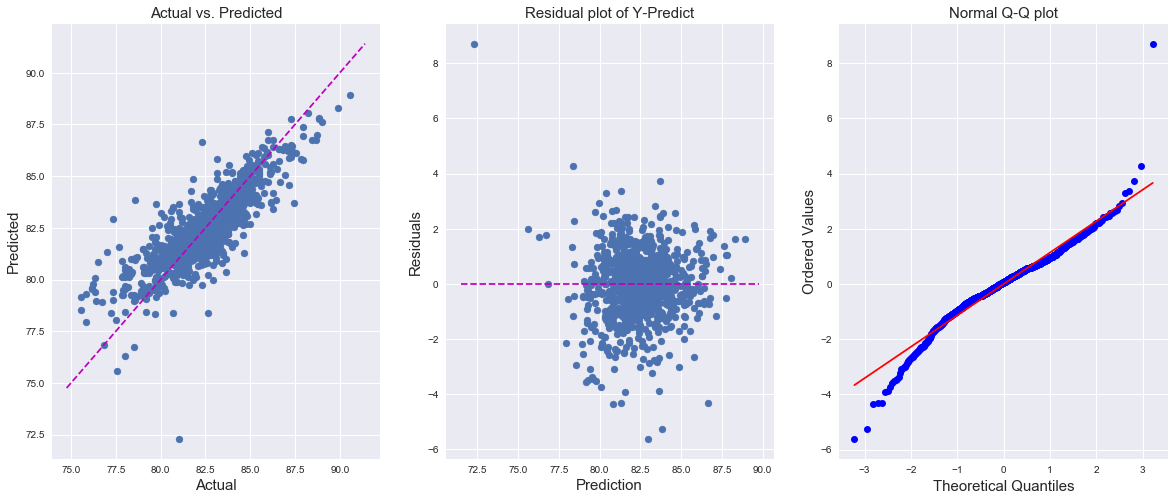

In [80]:
pred2 = fit2.predict(sm.add_constant(X_train[features2]))
print(calc_Rsq(y_train, pred2))

reg = LinearRegression()
scores = cross_val_score(reg, X_train[features2], y_train, cv=10, scoring='neg_mean_squared_error')
print("Model 2 CV Mean Squared Error: ", np.mean(-scores))

diagnostic_plot(y_train, pred2)

### Model 3: Use Grid Search Lasso Regularization to do Feature Selection on Logged Values
best_params:  {'alpha': 0.01}  
Final Selected Features: 46 Dropped: 18
{'r_squared: ': 0.68543322146445096,   
'adjusted_r_squared: ': 0.6652686843788389,   
'mean_root_error: ': 1.1634525898161512}  
Model 3 CV Mean Squared Error:  1.50967824981  

In [132]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso as Lasso
from sklearn.linear_model import LassoCV as LassoCV
from sklearn.preprocessing import StandardScaler

In [133]:
def Lasso_Feat_Select(X_train, y_train):
    ssX = StandardScaler()
    X_train_norm=ssX.fit_transform(X_train)

    reg = Lasso()
    grid = GridSearchCV(reg, cv=10, param_grid={'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0, 10., 100]}, 
                        scoring='neg_mean_squared_error')
    grid.fit(X_train_norm, y_train)
    print("best_params: ", grid.best_params_)
    print("best_score: ", -grid.best_score_)
    coefs=list(zip(X_train.columns, grid.best_estimator_.coef_))
    selected=[x for x in coefs if abs(x[1])>=0.01]
    print("Final Selected Features:", len(selected), 
          "Dropped:", X_train[features2].shape[1]-len(selected))
    return grid, selected, ssX

In [134]:
model3, selected_features3, ssX3 =Lasso_Feat_Select(X_train=X_train[features2], y_train=y_train)

best_params:  {'alpha': 0.01}
best_score:  1.50937813082
Final Selected Features: 42 Dropped: 22


{'r_squared: ': 0.68470344290217766, 'adjusted_r_squared: ': 0.66115041323849577, 'mean_root_error: ': 1.1648013827294708}
Model 3 CV Mean Squared Error:  1.50937813082


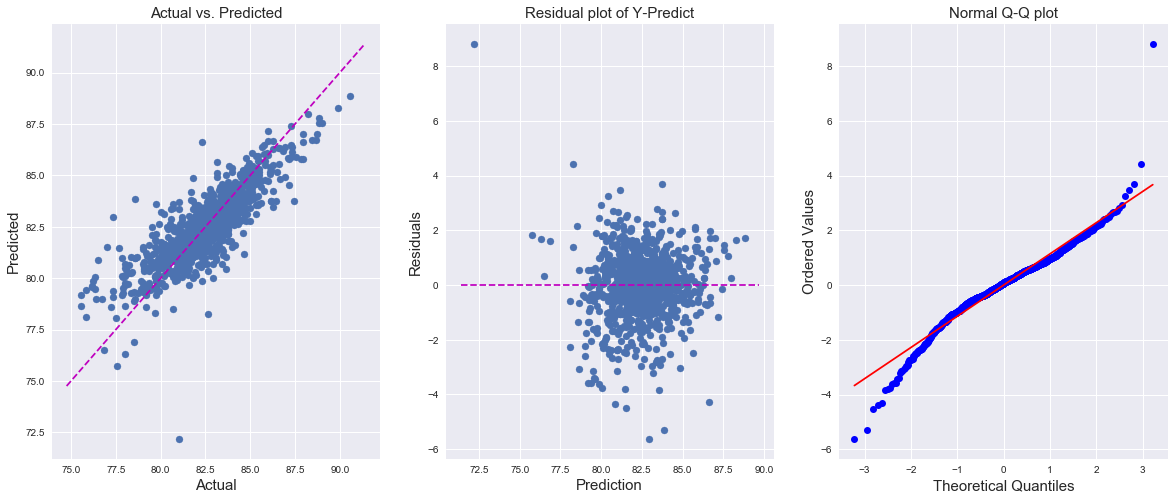

In [213]:
pred3 = model3.predict(ssX3.transform(X_train[features2]))
print(calc_Rsq(y_train, pred3))
print("Model 3 CV Mean Squared Error: ", -model3.best_score_)
diagnostic_plot(y_train, pred3)

In [218]:
sorted(pred3)[:5]

[72.184439103463106,
 75.740694727553119,
 76.320104887855521,
 76.501659973644976,
 76.884723804350216]

In [222]:
df_w_pred=pd.merge(pd.DataFrame(y_train), X_train[features2], how="outer", left_index=True, right_index=True)
df_w_pred=pd.merge(pd.DataFrame(pred3, columns=["Predict_Score"]), df_w_pred, how="outer", left_index=True, right_index=True)
df_w_pred['Residual']=df_w_pred.Total_Score - df_w_pred.Predict_Score
df_w_pred.sort_values(by=['Predict_Score']).head()

,Predict_Score,Total_Score,Altitude_log,Sweetness_log,Quakers_log,Defects_cat1_log,Defects_cat2_log,Grading_year,Acidity,Moisture,...,Country_Rwanda,Country_Taiwan,"Country_Tanzania,_United_Republic_Of",Country_Thailand,Country_Uganda,Country_United_States_Hawaii,Country_United_States_Puerto_Rico,Country_Vietnam,Country_Zambia,Residual
338,72.184439,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
614,75.740695,81.08,7.090077,2.302585,0.0,0.0,0.000000,2012.0,7.42,0.10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.339305
759,76.320105,80.75,7.170120,2.302585,0.0,0.0,0.000000,2014.0,7.25,0.11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.429895
713,76.501660,81.75,7.438384,2.302585,0.0,0.0,0.000000,2017.0,7.42,0.11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.248340
956,76.884724,82.42,7.170120,2.302585,0.0,0.0,2.197225,2012.0,7.58,0.14,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.535276


In [224]:
df_w_pred[df_w_pred['Predict_Score']<=75]

,Predict_Score,Total_Score,Altitude_log,Sweetness_log,Quakers_log,Defects_cat1_log,Defects_cat2_log,Grading_year,Acidity,Moisture,...,Country_Rwanda,Country_Taiwan,"Country_Tanzania,_United_Republic_Of",Country_Thailand,Country_Uganda,Country_United_States_Hawaii,Country_United_States_Puerto_Rico,Country_Vietnam,Country_Zambia,Residual
338,72.184439,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [231]:
print(len(selected_features3))
selected_features3_sorted=sorted(selected_features3, key=itemgetter(1), reverse=True)
selected_features3_sorted[:10], selected_features3_sorted[-10:], 

42


([('Acidity', 1.4416489895964311),
  ('Sweetness_log', 0.53826071637021766),
  ('Country_Ethiopia', 0.11838983155526575),
  ('Country_Colombia', 0.10439415215324575),
  ('Country_India', 0.098786341393547583),
  ('Variety_gr_Caturra', 0.092075766953420804),
  ('Country_Uganda', 0.085700382300807398),
  ('Country_El_Salvador', 0.064328563592097321),
  ('Variety_gr_Other', 0.060858277308919899),
  ('Processing_meth_Natural_Dry', 0.052948131028187649)],
 [('Country_Myanmar', -0.042959160227160877),
  ('Color_Green', -0.043488301134393413),
  ('Country_United_States_Puerto_Rico', -0.057529398316419282),
  ('Country_United_States_Hawaii', -0.074114792988463213),
  ('Variety_gr_Typica', -0.076345750001225829),
  ('Country_Thailand', -0.082053244633863487),
  ('Processing_meth_Washed_Wet', -0.087241507718872319),
  ('Country_Mexico', -0.1303090468740507),
  ('Defects_cat2_log', -0.14207597340924338),
  ('Country_Guatemala', -0.18948636642286942)])

### Model 4 Transform into Polynomials and Logs, then Use GridSearch to find the best alpha
**Cubic Transformation indicates overfitting**  
best_params:  {'alpha': 0.02}  
best_score:  2.00125756418  
Final Selected Features: 63 Dropped: 212  

**Back to Quadratic Transformation (much better) **   
best_params:  {'alpha': 0.02}  
best_score:  1.51543467208  
Final Selected Features: 31 Dropped: 79  


In [136]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline, Pipeline

In [137]:
def preprocess(X, degree=3, ssX=None):
    """Should only be applied to scaled data"""
    X_to_raise = X.iloc[:, :9].values
    poly = PolynomialFeatures(degree)
    if (ssX is None):
        ssX = StandardScaler()
        ssX.fit(X_to_raise)
    X_scaled = ssX.transform(X_to_raise)
    X_scaled2 = poly.fit_transform(X_scaled)
    X_scaled_w_dummy = np.concatenate([X_scaled2, X.values[:, 9:]], axis=1)
    
    names=list(poly.get_feature_names())
    names=[name.replace('x0', 'Altitude_log')\
        .replace('x1', 'Sweetness_log')\
        .replace('x2', 'Quakers_log')\
        .replace('x3', 'Defects_cat1_log')\
        .replace('x4', 'Defects_cat2_log')\
        .replace('x5', 'Grading_year')\
        .replace('x6', 'Acidity')\
        .replace('x7', 'Moisture')\
        .replace('x8', 'total_weight')
        for name in names
        ]

    X_scaled_w_dummy = pd.DataFrame(X_scaled_w_dummy, 
                                    columns=[names + list(X.columns[9:])])
    return X_scaled_w_dummy, ssX

In [138]:
def Lasso_Feat_Select2(X_train, y_train, degree=3):
    X_train_norm, ssX = preprocess(X_train, degree, None)

    reg = Lasso()
    grid = GridSearchCV(reg, cv=10, param_grid={'alpha': [0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.5, 1.0]}, 
                        scoring='neg_mean_squared_error')
    grid.fit(X_train_norm, y_train)
    print("best_params: ", grid.best_params_)
    print("best_score: ", -grid.best_score_)
    coefs=list(zip(X_train_norm.columns, grid.best_estimator_.coef_))
    selected=[x for x in coefs if abs(x[1])>=0.01]
    print("Final Selected Features:", len(selected), 
          "Dropped:", X_train_norm.shape[1]-len(selected))
    return grid, selected, ssX

In [139]:
model4_cub, selected_features4_cub, ssX4_cub = Lasso_Feat_Select2(X_train[features2], y_train, degree=3)

best_params:  {'alpha': 0.05}
best_score:  2.43308232059
Final Selected Features: 26 Dropped: 249


In [140]:
model4_2, selected_features4_2, ssX4_2 = Lasso_Feat_Select2(X_train[features2], y_train, degree=2)

best_params:  {'alpha': 0.05}
best_score:  1.52601569586
Final Selected Features: 16 Dropped: 94


In [141]:
print(len(selected_features4_2))
selected_features4_2_sorted=sorted(selected_features4_2, key=itemgetter(1), reverse=True)
selected_features4_2_sorted[:5], selected_features4_2_sorted[-5:], 

16


([('Acidity', 1.5135007423485813),
  ('Sweetness_log', 0.65122375135640476),
  ('Country_Colombia', 0.1263282394201091),
  ('Acidity^2', 0.099570210320615693),
  ('Acidity Moisture', 0.079739626330858626)],
 [('Moisture', -0.049748138721315865),
  ('Country_Mexico', -0.098647510774532821),
  ('Defects_cat2_log', -0.10030429868493485),
  ('Processing_meth_Washed_Wet', -0.12851547514528833),
  ('Country_Guatemala', -0.19137830268760639)])

(1080, 110)
1080 <class 'numpy.ndarray'>
{'r_squared: ': 0.67941097308428799, 'adjusted_r_squared: ': 0.65886039443584488, 'mean_root_error: ': 1.174536695894451}


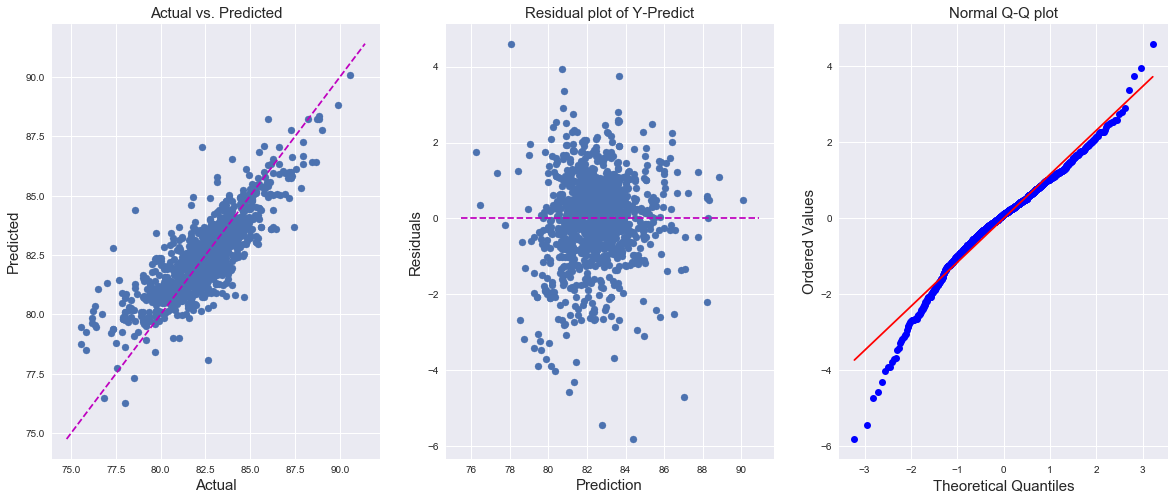

In [142]:
X_train_transformed, ssX4_2 = preprocess(X_train[features2], degree=2, ssX = ssX4_2)
print(X_train_transformed.shape)
pred4_2=model4_2.predict(X_train_transformed)
print(len(pred4_2), type(pred4_2))
print(calc_Rsq(y_train, pred4_2))
diagnostic_plot(y_train, pred4_2)

### Model 5 Try Ridge Regression for Feature Selection
Cubic:  
best_params:  {'alpha': 1.0}  
best_score:  51.9488398889  
Final Selected Features: 250 Dropped: 25  

Quadratic:
best_params:  {'alpha': 1.0}  
best_score:  5.73428442164  
Final Selected Features: 102 Dropped: 8  

In [143]:
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge

In [144]:
def Ridge_Feat_Select(X_train, y_train, degree=3):
    X_train_norm, ssX = preprocess(X_train, degree, None)

    reg = Ridge()
    grid = GridSearchCV(reg, cv=10, param_grid={'alpha': [0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.5, 1.0]}, 
                        scoring='neg_mean_squared_error')
    grid.fit(X_train_norm, y_train)
    print("best_params: ", grid.best_params_)
    print("best_score: ", -grid.best_score_)
    coefs=list(zip(X_train_norm.columns, grid.best_estimator_.coef_))
    selected=[x for x in coefs if abs(x[1])>=0.01]
    print("Final Selected Features:", len(selected), 
          "Dropped:", X_train_norm.shape[1]-len(selected))
    return grid, selected, ssX

In [145]:
model5_cub, selected_features5_cub, ssX5_cub = Ridge_Feat_Select(X_train[features2], y_train, degree=3)

best_params:  {'alpha': 1.0}
best_score:  77.3349155859
Final Selected Features: 250 Dropped: 25


In [146]:
model5_2, selected_features5_2, ssX5_2 = Ridge_Feat_Select(X_train[features2], y_train, degree=2)

best_params:  {'alpha': 1.0}
best_score:  6.40542263622
Final Selected Features: 101 Dropped: 9


{'r_squared: ': 0.72435866900182577, 'adjusted_r_squared: ': 0.70668935291219925, 'mean_root_error: ': 1.0890916603044571}


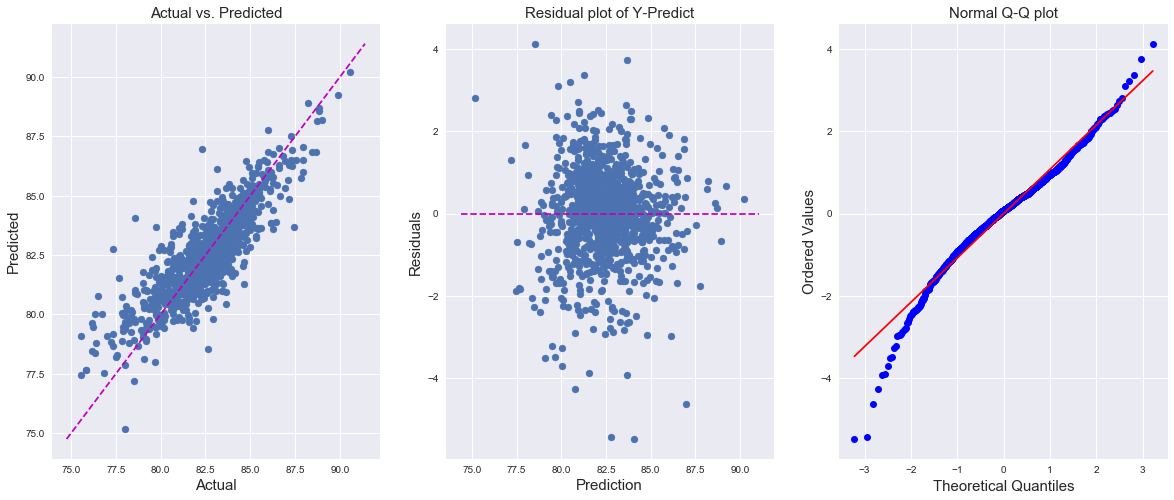

In [147]:
X_train_transformed, ssX5_2 = preprocess(X_train[features2], degree=2, ssX = ssX5_2)
X_train_transformed.shape
pred5_2 = model5_2.predict(X_train_transformed)
print(calc_Rsq(y_train, pred5_2))
diagnostic_plot(y_train, pred5_2)

In [149]:
selected_features5_2_sorted=sorted(selected_features5_2, key=itemgetter(1), reverse=True)
selected_features5_2_sorted[:10], selected_features5_2_sorted[-10:], 

([('Acidity', 1.5089474222384698),
  ('Sweetness_log', 0.97665795974586067),
  ('Country_El_Salvador', 0.6739384663184923),
  ('Country_Uganda', 0.53993068129005317),
  ('Country_Rwanda', 0.48153966663820597),
  ('Country_Colombia', 0.36651716713459875),
  ('Country_Ethiopia', 0.3628782379629098),
  ('Country_Zambia', 0.36111416885891945),
  ('Country_Costa_Rica', 0.35735878825801304),
  ('Country_Panama', 0.34086633557839924)],
 [('Variety_gr_SL28', -0.30164612002700791),
  ('Country_Guatemala', -0.44459386331308753),
  ('Country_Cote_d?Ivoire', -0.4531735735083901),
  ('Country_Thailand', -0.45964578801097156),
  ('Country_United_States_Hawaii', -0.48790610099892218),
  ('Country_Burundi', -0.59113843923237452),
  ('Country_Myanmar', -0.63099885443101145),
  ('Country_Papua_New_Guinea', -0.6855465297178841),
  ('Country_India', -0.69677637143104365),
  ('Country_United_States_Puerto_Rico', -0.70853558770596825)])

### Test My Final Model
Based on my results above, I select Model 3 Lasso on selected features with alpha = 0.02, and no polynomial terms. Transform the X_test the same exact ways as X_train (including scaler) in order to predict y_test

In [150]:
X_test['Altitude_log'] = [log_var(x) for x in X_test['Altitude']]
X_test['Sweetness_log'] = [log_var(x) for x in X_test['Sweetness']]
X_test['Defects_cat1_log'] = [log_var(x) for x in X_test['Defects_cat1']]
X_test['Defects_cat2_log'] = [log_var(x) for x in X_test['Defects_cat2']]
X_test['Quakers_log'] = [log_var(x) for x in X_test['Quakers']]

(270, 110)
{'r_squared: ': 0.64778081493101913, 'adjusted_r_squared: ': 0.53555411380609885, 'mean_root_error: ': 1.2486759112433863}


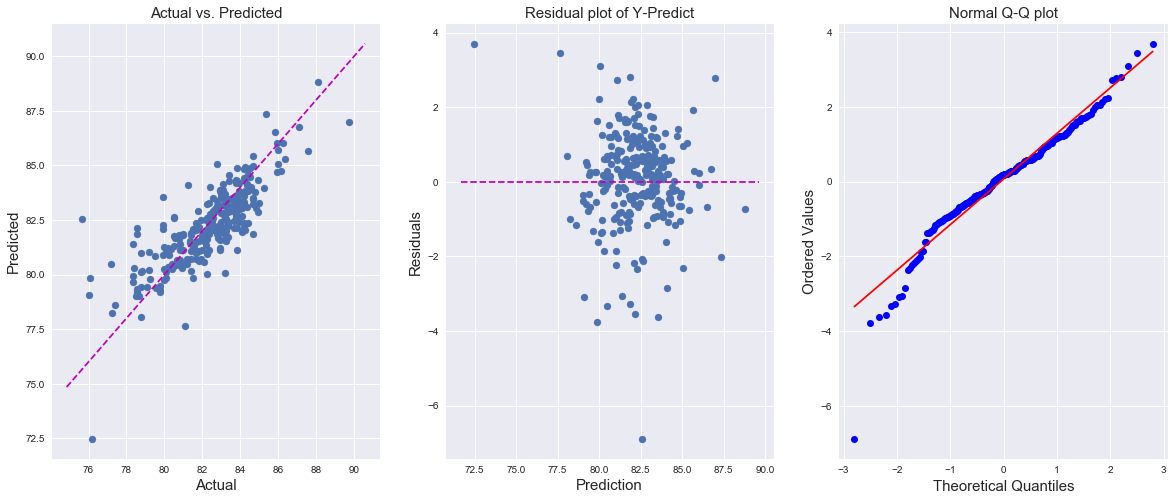

In [151]:
X_test_norm5_2, ssX5_2 = preprocess(X_test[features2], degree=2, ssX = ssX5_2)
print(X_test_norm5_2.shape)
pred_test52 = model5_2.predict(X_test_norm5_2)
print(calc_Rsq(y_test, pred_test52))
diagnostic_plot(y_test, pred_test52)

(270, 110)
{'r_squared: ': 0.6422620190699273, 'adjusted_r_squared: ': 0.52827687808730617, 'mean_root_error: ': 1.2584204159253511}


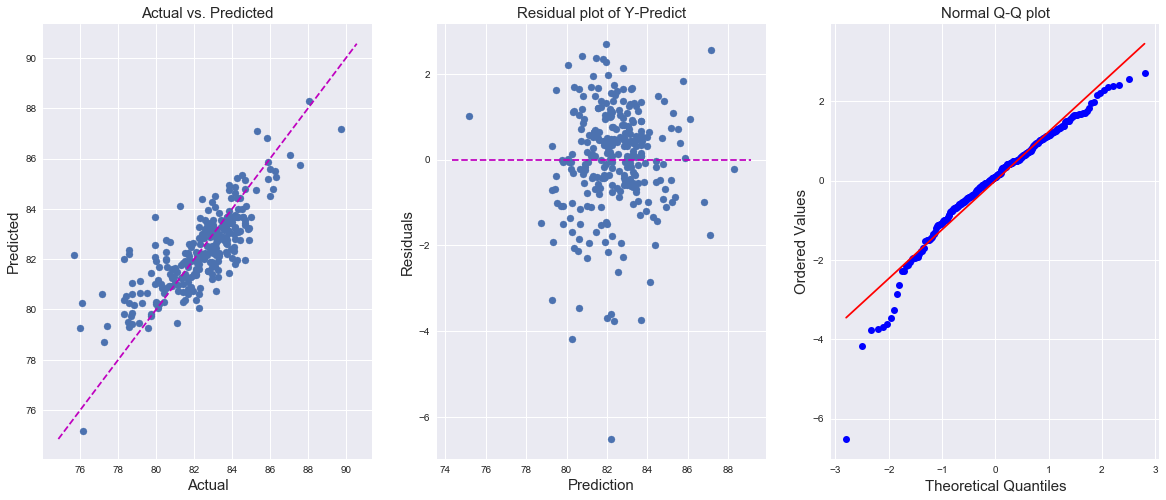

In [152]:
X_test_norm4_2, ssX4_2 = preprocess(X_test[features2], degree=2, ssX = ssX4_2)
print(X_test_norm4_2.shape)
pred_test42 = model4_2.predict(X_test_norm4_2)
print(calc_Rsq(y_test, pred_test42))
diagnostic_plot(y_test, pred_test42)

{'r_squared: ': 0.68088012514292107, 'adjusted_r_squared: ': 0.57919977286002822, 'mean_root_error: ': 1.1885573886518643}


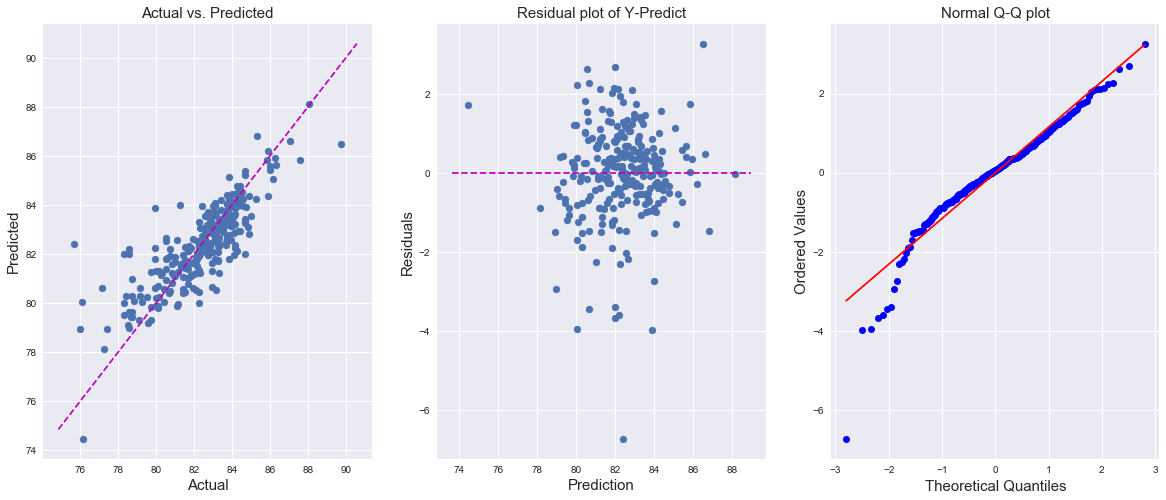

In [153]:
X_test_norm3=ssX3.transform(X_test[features2])
pred_test3 = model3.predict(X_test_norm3)
print(calc_Rsq(y_test, pred_test3))
diagnostic_plot(y_test, pred_test3)

### Final Model with all data

In [154]:
#Transform the data
df2=df.copy()
df2['Altitude_log'] = [log_var(x) for x in df2['Altitude']]
df2['Sweetness_log'] = [log_var(x) for x in df2['Sweetness']]
df2['Defects_cat1_log'] = [log_var(x) for x in df2['Defects_cat1']]
df2['Defects_cat2_log'] = [log_var(x) for x in df2['Defects_cat2']]
df2['Quakers_log'] = [log_var(x) for x in df2['Quakers']]

In [155]:
y = df2['Total_Score']
X = df2.drop(['Total_Score'], axis=1)

In [ ]:
# df_norm=ssX3.transform(X[features2])
# pred_df = model3.predict(df_norm)
# print(calc_Rsq(y, pred_df))
# diagnostic_plot(y, pred_df)

{'r_squared: ': 0.68654634498132372, 'adjusted_r_squared: ': 0.66809342180518505, 'mean_root_error: ': 1.1649812608825982}


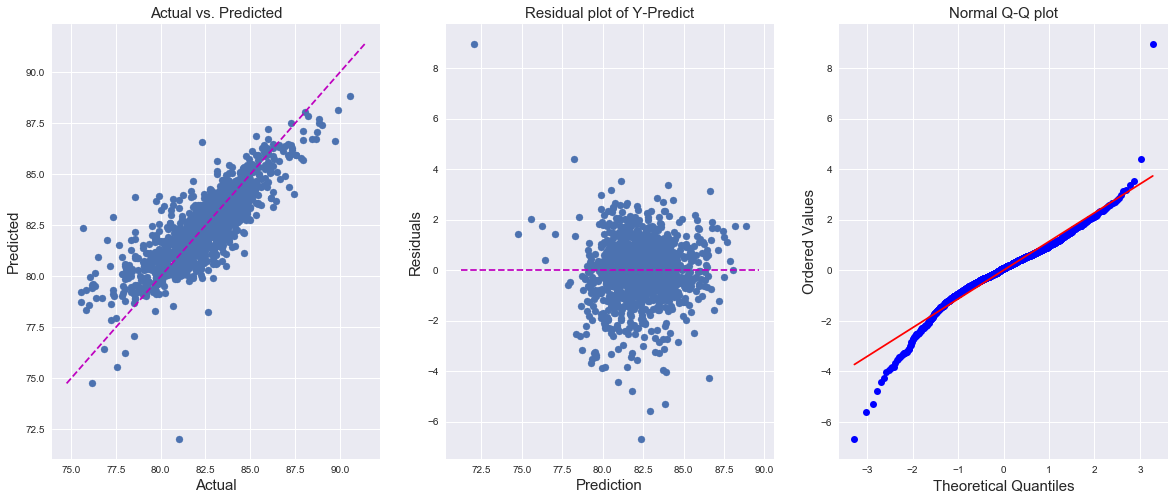

In [156]:
#fit transform & choose alpha for entire data set
df_norm=ssX3.transform(X[features2])
reg_f = Lasso(alpha=0.01)
model_f = reg_f.fit(df_norm, y)
pred_f = model_f.predict(df_norm)
print(calc_Rsq(y, pred_f))
diagnostic_plot(y, pred_f)

** OLS **

In [157]:
model_f2 = sm.OLS(y, sm.add_constant(X[[ names for names, values in selected_features3]]))
fit_f2 = model_f2.fit()
fit_f2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Total_Score   R-squared:                       0.687
Model:                            OLS   Adj. R-squared:                  0.677
Method:                 Least Squares   F-statistic:                     68.39
Date:                Thu, 19 Jul 2018   Prob (F-statistic):          7.71e-296
Time:                        14:01:33   Log-Likelihood:                -2120.1
No. Observations:                1350   AIC:                             4326.
Df Residuals:                    1307   BIC:                             4550.
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
const                                      54.1003     39.800      1.359      0.174     -23.978     132.179
Sweetness_log                              14.3046      0.969     14.758      0.000      12.403      16.206
Quakers_log                                 0.0417      0.127      0.328      0.743      -0.208       0.291
Defects_cat1_log                           -0.0693      0.101     -0.683      0.495      -0.268       0.130
Defects_cat2_log                           -0.1381      0.042     -3.324      0.001      -0.220      -0.057
Grading_year                               -0.0199      0.020     -1.006      0.315      -0.059       0.019
Acidity                                     4.7727      0.118     40.520      0.000       4.542       5.004
Moisture                                   -1.0895      0.783     -1.391      0.164      -2.626       0.447
Color_Bluish_Green                          0.0178      0.139      0.128      0.898      -0.255       0.290
Color_Green                                -0.1534      0.088     -1.738      0.082      -0.327       0.020
Processing_meth_Natural_Dry                 0.1303      0.133      0.983      0.326      -0.130       0.391
Processing_meth_Semi_washed_Semi_pulped     0.1516      0.195      0.777      0.437      -0.231       0.534
Processing_meth_Washed_Wet                 -0.1583      0.119     -1.326      0.185      -0.393       0.076
Variety_gr_Catimor                          0.6003      0.268      2.243      0.025       0.075       1.125
Variety_gr_Caturra                          0.2387      0.111      2.159      0.031       0.022       0.456
Variety_gr_Mundo_Novo                      -0.1309      0.227     -0.577      0.564      -0.576       0.315
Variety_gr_Other                            0.1789      0.122      1.470      0.142      -0.060       0.418
Variety_gr_Pacas                           -0.4404      0.352     -1.252      0.211      -1.130       0.250
Variety_gr_Typica                          -0.1917      0.129     -1.491      0.136      -0.444       0.060
Country_Brazil                             -0.0037      0.173     -0.021      0.983      -0.342       0.335
Country_Burundi                            -0.2300      0.846     -0.272      0.786      -1.890       1.430
Country_Colombia                            0.2587      0.160      1.615      0.107      -0.056       0.573
Country_Costa_Rica                          0.2152      0.206      1.043      0.297      -0.190       0.620
Country_El_Salvador                         0.4744      0.283      1.675      0.094      -0.081       1.030
Country_Ethiopia                            0.5446      0.216      2.521      0.012       0.121       0.968
Country_Guatemala                          -0.6038      0.1

In [158]:
print('R2: ', fit_f2.rsquared_adj)
params = fit_f2.params
params.sort_values(ascending=False)

R2:  0.677234216954


const                                      54.100338
Sweetness_log                              14.304611
Acidity                                     4.772664
Country_India                               3.787778
Country_Uganda                              0.658962
Variety_gr_Catimor                          0.600310
Country_Ethiopia                            0.544605
Country_El_Salvador                         0.474369
Country_Colombia                            0.258711
Variety_gr_Caturra                          0.238662
Country_Costa_Rica                          0.215198
Variety_gr_Other                            0.178882
Country_Panama                              0.153415
Processing_meth_Semi_washed_Semi_pulped     0.151562
Country_Kenya                               0.149882
Processing_meth_Natural_Dry                 0.130336
Country_Indonesia                           0.121870
Quakers_log                                 0.041656
Color_Bluish_Green                          0.

In [159]:
fit_f2.params[fit_f2.pvalues<=0.05]

Sweetness_log                   14.304611
Defects_cat2_log                -0.138129
Acidity                          4.772664
Variety_gr_Catimor               0.600310
Variety_gr_Caturra               0.238662
Country_Ethiopia                 0.544605
Country_Guatemala               -0.603798
Country_India                    3.787778
Country_Mexico                  -0.527177
Country_Myanmar                 -1.286766
Country_Thailand                -0.526626
Country_Uganda                   0.658962
Country_United_States_Hawaii    -0.662849
dtype: float64

### Try Random Forest

In [160]:
from sklearn import linear_model,ensemble, tree, model_selection, datasets

In [178]:
models = {}
parameters = {}

models['linear_model'] = linear_model.LinearRegression()
models['ridge_model'] = linear_model.Ridge()
models['lasso_model'] = linear_model.Lasso(alpha=.01)
models['robust_regression'] = linear_model.SGDRegressor(loss='huber',max_iter=2000)
models['eps_insensitive'] = linear_model.SGDRegressor(loss='epsilon_insensitive',max_iter=2000)


models['cart'] = tree.DecisionTreeRegressor(max_depth=2)
models['extratrees'] = tree.ExtraTreeRegressor(max_depth=2)
models['randomForest'] = ensemble.RandomForestRegressor()
models['adaboostedTrees'] = ensemble.AdaBoostRegressor()
models['gradboostedTrees'] = ensemble.GradientBoostingRegressor()


for name,model in models.items():
    scores = model_selection.cross_val_score(model, X_train[features2], y_train, n_jobs=1)
    print('Model: '+name)
    print("Score: " + str(np.mean(scores)))
    print()



Model: linear_model
Score: 0.639931517252

Model: ridge_model
Score: 0.632205659069

Model: lasso_model
Score: 0.636722006834

Model: robust_regression
Score: -3.12779031469e+14

Model: eps_insensitive
Score: -4.31439695344e+16

Model: cart
Score: 0.482031099994

Model: extratrees
Score: 0.21766434761

Model: randomForest
Score: 0.619615369846

Model: adaboostedTrees
Score: 0.567088546216

Model: gradboostedTrees
Score: 0.65803682125



In [172]:
coefs = models['gradboostedTrees'].fit(X_train[features2], y_train).feature_importances_
print(len(coefs[coefs>=0.005]))
coefs=pd.DataFrame(sorted(zip(features2,coefs), key = lambda x:x[1], reverse=True), columns=['Feature', 'Feature_Importance'])
coefs[coefs['Feature_Importance']>=0.005]

29


,Feature,Feature_Importance
0,Acidity,0.266680
1,Altitude_log,0.099312
2,Defects_cat2_log,0.077077
3,Sweetness_log,0.064789
4,Moisture,0.054359
5,Defects_cat1_log,0.054295
6,total_weight,0.052282
7,Country_Guatemala,0.029588
8,Country_Mexico,0.025183
9,Grading_year,0.021833


In [176]:
def Random_Forest(X, y):
    ssX = StandardScaler()
    X_norm=ssX.fit_transform(X)

    reg = ensemble.GradientBoostingRegressor()
    grid = GridSearchCV(reg, cv=10, param_grid={'max_depth': np.arange(1,11)}, 
                        scoring='neg_mean_squared_error')
    grid.fit(X_norm, y)
    print("best_params: ", grid.best_params_)
    print("best_score: ", -grid.best_score_)
    
    coefs=pd.DataFrame(sorted(zip(X.columns, grid.best_estimator_.feature_importances_), 
                              key = lambda x:x[1], reverse=True), 
                       columns=['Feature', 'Feature_Importance'])
    selected=coefs[coefs['Feature_Importance']>=0.005]
    
    print("Final Selected Features:", len(selected), 
          "Dropped:", X_train[features2].shape[1]-len(selected))
    
#     coefs=list(zip(X.columns, grid.best_estimator_.coef_))
#     selected=[x for x in coefs if abs(x[1])>=0.01]
#     print("Final Selected Features:", len(selected), 
#           "Dropped:", X_train[features2].shape[1]-len(selected))
    return grid, selected, ssX

In [177]:
Random_Forest(X_train[features2], y_train)

best_params:  {'max_depth': 2}
best_score:  1.40634484012
Final Selected Features: 22 Dropped: 42


(GridSearchCV(cv=10, error_score='raise',
        estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
              max_leaf_nodes=None, min_impurity_decrease=0.0,
              min_impurity_split=None, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False),
        fit_params=None, iid=True, n_jobs=1,
        param_grid={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])},
        pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
        scoring='neg_mean_squared_error', verbose=0),
                          Feature  Feature_Importance
 0                        Acidity            0.328584
 1                  Sweetness_log            0.122151
 2               Defects_cat2_log            0.093200
 3      

In [ ]:
X_reduced = X[['F4','F2','F1','F5','F3',1]]

for name,model in models.items():
    scores = model_selection.cross_val_score(model, X_reduced, y, n_jobs=-1)
    print('Model: '+name)
    print("Score: " + str(np.mean(scores)))
    print()

### Make plot for Presentation

In [238]:
def diagnostic_plot(y, pred):
    plt.figure(figsize=(30,10))
    res = y - pred
    
    plt.subplot(1, 3, 1)
    plt.scatter(y, pred)
    plt.plot(np.linspace(y.min()-0.01*np.mean(y), y.max()+0.01*np.mean(y), 1000),
         np.linspace(y.min()-0.01*np.mean(y), y.max()+0.01*np.mean(y), 1000),
        color='m', linestyle='--')
    plt.title("Actual vs. Predicted", size=40)
    plt.xlabel("Actual", size=40)
    plt.ylabel("Predicted", size=40)

    plt.subplot(1, 3, 2)
    plt.scatter(pred, res)
    plt.plot(np.linspace(pred.min()-0.01*np.mean(pred), pred.max()+0.01*np.mean(pred), 1000), 
             np.linspace(0, 0, 1000), 
             color='m', linestyle='--')
    plt.title("Residual plot of Y-Predict", size=40)
    plt.xlabel("Prediction", size=40)
    plt.ylabel("Residuals", size=40)

    plt.subplot(1, 3, 3)
    stats.probplot(res, dist="norm", plot=plt)
    plt.xlabel("Theoretical Quantiles", size=40)
    plt.ylabel("Ordered Values", size=40)
    plt.title("Normal Q-Q plot", size=40)

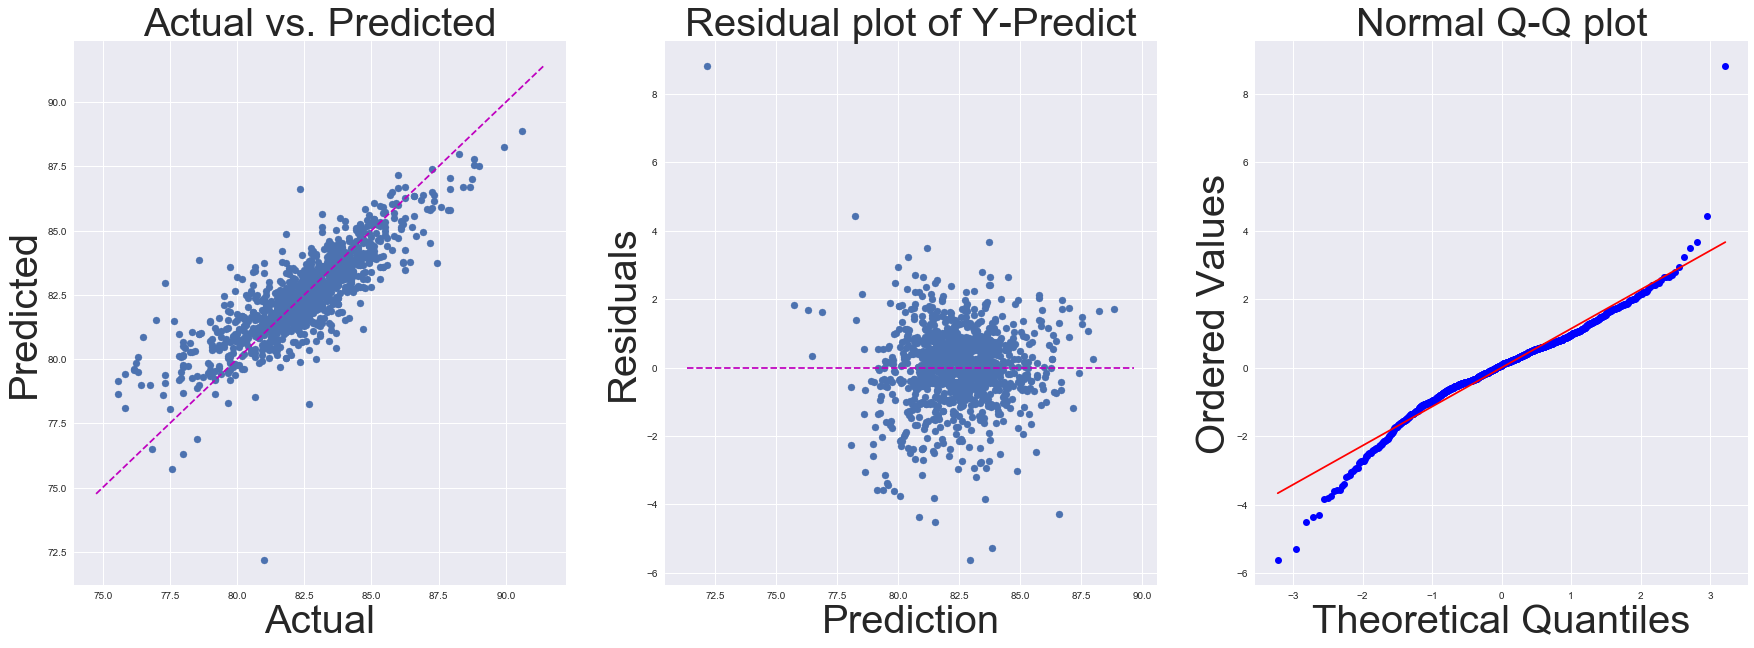

In [239]:
diagnostic_plot(y_train, pred3)